In [1]:
import warnings
import os

os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')

# Загружаем последовательности с метками из очищенных файлов

In [2]:
import os
import pandas as pd
from Bio import SeqIO

# Путь к главной директории
base_dir = "generated_graphs"

records = []

# Фильтрация директорий по префиксу
target_dirs = [d for d in os.listdir(base_dir)
               if os.path.isdir(os.path.join(base_dir, d)) and (d.startswith("anopheles") or d.startswith("insect"))]

# Обработка каждой подходящей директории
for organism_dir in target_dirs:
    full_path = os.path.join(base_dir, organism_dir)
    graph_labels_path = os.path.join(full_path, "graph_labels.csv")
    sequences_path = os.path.join(full_path, "sequences.csv")

    if not os.path.isfile(graph_labels_path) or not os.path.isfile(sequences_path):
        continue

    # Чтение меток
    labels_df = pd.read_csv(graph_labels_path)
    labels_dict = dict(zip(labels_df["graph_id"], labels_df["label"]))

    # Чтение последовательностей
    for record in SeqIO.parse(sequences_path, "fasta"):
        seq_id = record.id
        sequence = str(record.seq)
        label = labels_dict[int(seq_id)]
        records.append({"sequence": sequence, "label": label, "organism": organism_dir})

# Создание итогового DataFrame
result_df = pd.DataFrame(records)

In [3]:
print(result_df.shape)
print(result_df)

(3006, 3)
                                               sequence  label  \
0     TGTTGCGAGCTATAGGGGTTCGGGAATATAAATGCCACTCTTCTTC...  gypsy   
1     GTCATAATAAGTGAATTTTTTTTTTTTTTTTTTTTTTTTTAAAAGG...   line   
2     AGGTGAACTGTCAGCGATTGGAATGACGGATGTCAATTCGATAGCA...   line   
3     AAGAACATAATAATAATAATAATAATAATAATAATAATAATAATCC...     l1   
4     AGTTTTGTGTGGGATAGTGGCGATTAATTCAGACGAAACAACACTT...  gypsy   
...                                                 ...    ...   
3001  AAATGACACAAACAACAAAAAACTTACGAAAGAAATTATTTAAAGA...   line   
3002  TCCACTCCCACCTCCACTTTCCGCTCTGACTATAGATTCAATTATA...  gypsy   
3003  ATTATTAAATTTAATATATTCGGTTTTTCGCGGGTAGGCGTGAAAC...     l1   
3004  ATACATGGTCTTTGTCTATGTAAGTGCAAATACGCTAAAAAAAAAA...   line   
3005  TTTATTTATTTATATATACTTTATTGCACAGATTACAAAAAAAGAA...   line   

                                 organism  
0         insect_euchloe_belemia_filtered  
1         insect_euchloe_belemia_filtered  
2         insect_euchloe_belemia_filtered  
3         insect_euch

In [4]:
# From: https://github.com/dariush-bahrami/character-tokenizer/blob/master/charactertokenizer/core.py
import json
import os
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Union

from transformers.tokenization_utils import AddedToken, PreTrainedTokenizer


class CharacterTokenizer(PreTrainedTokenizer):
    def __init__(self, characters: Sequence[str], model_max_length: int, padding_side: str='left', **kwargs):
        """Character tokenizer for Hugging Face transformers.
        Args:
            characters (Sequence[str]): List of desired characters. Any character which
                is not included in this list will be replaced by a special token called
                [UNK] with id=6. Following are list of all of the special tokens with
                their corresponding ids:
                    "[CLS]": 0
                    "[SEP]": 1
                    "[BOS]": 2
                    "[MASK]": 3
                    "[PAD]": 4
                    "[RESERVED]": 5
                    "[UNK]": 6
                an id (starting at 7) will be assigned to each character.
            model_max_length (int): Model maximum sequence length.
        """
        self.characters = characters
        self.model_max_length = model_max_length
        bos_token = AddedToken("[BOS]", lstrip=False, rstrip=False)
        eos_token = AddedToken("[SEP]", lstrip=False, rstrip=False)
        sep_token = AddedToken("[SEP]", lstrip=False, rstrip=False)
        cls_token = AddedToken("[CLS]", lstrip=False, rstrip=False)
        pad_token = AddedToken("[PAD]", lstrip=False, rstrip=False)
        unk_token = AddedToken("[UNK]", lstrip=False, rstrip=False)

        mask_token = AddedToken("[MASK]", lstrip=True, rstrip=False)

        super().__init__(
            bos_token=bos_token,
            eos_token=sep_token,
            sep_token=sep_token,
            cls_token=cls_token,
            pad_token=pad_token,
            mask_token=mask_token,
            unk_token=unk_token,
            add_prefix_space=False,
            model_max_length=model_max_length,
            padding_side=padding_side,
            **kwargs,
        )

        self._vocab_str_to_int = {
            "[CLS]": 0,
            "[SEP]": 1,
            "[BOS]": 2,
            "[MASK]": 3,
            "[PAD]": 4,
            "[RESERVED]": 5,
            "[UNK]": 6,
            **{ch: i + 7 for i, ch in enumerate(characters)},
        }
        self._vocab_int_to_str = {v: k for k, v in self._vocab_str_to_int.items()}

    @property
    def vocab_size(self) -> int:
        return len(self._vocab_str_to_int)

    def _tokenize(self, text: str) -> List[str]:
        return list(text)

    def _convert_token_to_id(self, token: str) -> int:
        return self._vocab_str_to_int.get(token, self._vocab_str_to_int["[UNK]"])

    def _convert_id_to_token(self, index: int) -> str:
        return self._vocab_int_to_str[index]

    def convert_tokens_to_string(self, tokens):
        return "".join(tokens)

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        result = cls + token_ids_0 + sep
        if token_ids_1 is not None:
            result += token_ids_1 + sep
        return result

    def get_special_tokens_mask(
        self,
        token_ids_0: List[int],
        token_ids_1: Optional[List[int]] = None,
        already_has_special_tokens: bool = False,
    ) -> List[int]:
        if already_has_special_tokens:
            return super().get_special_tokens_mask(
                token_ids_0=token_ids_0,
                token_ids_1=token_ids_1,
                already_has_special_tokens=True,
            )

        result = [1] + ([0] * len(token_ids_0)) + [1]
        if token_ids_1 is not None:
            result += ([0] * len(token_ids_1)) + [1]
        return result

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]

        result = len(cls + token_ids_0 + sep) * [0]
        if token_ids_1 is not None:
            result += len(token_ids_1 + sep) * [1]
        return result

    def get_config(self) -> Dict:
        return {
            "char_ords": [ord(ch) for ch in self.characters],
            "model_max_length": self.model_max_length,
        }

    @classmethod
    def from_config(cls, config: Dict) -> "CharacterTokenizer":
        cfg = {}
        cfg["characters"] = [chr(i) for i in config["char_ords"]]
        cfg["model_max_length"] = config["model_max_length"]
        return cls(**cfg)

    def save_pretrained(self, save_directory: Union[str, os.PathLike], **kwargs):
        cfg_file = Path(save_directory) / "tokenizer_config.json"
        cfg = self.get_config()
        with open(cfg_file, "w") as f:
            json.dump(cfg, f, indent=4)

    @classmethod
    def from_pretrained(cls, save_directory: Union[str, os.PathLike], **kwargs):
        cfg_file = Path(save_directory) / "tokenizer_config.json"
        with open(cfg_file) as f:
            cfg = json.load(f)
        return cls.from_config(cfg)

In [5]:
# %cd hyena_dna
# from standalone_hyenadna import HyenaDNAModel

In [6]:
#@title Huggingface Pretrained Wrapper
# for Huggingface integration, we use a wrapper class around the model
# to load weights
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig
import re

def inject_substring(orig_str):
    """Hack to handle matching keys between models trained with and without
    gradient checkpointing."""

    # modify for mixer keys
    pattern = r"\.mixer"
    injection = ".mixer.layer"

    modified_string = re.sub(pattern, injection, orig_str)

    # modify for mlp keys
    pattern = r"\.mlp"
    injection = ".mlp.layer"

    modified_string = re.sub(pattern, injection, modified_string)

    return modified_string

def load_weights(scratch_dict, pretrained_dict, checkpointing=False):
    """Loads pretrained (backbone only) weights into the scratch state dict.

    scratch_dict: dict, a state dict from a newly initialized HyenaDNA model
    pretrained_dict: dict, a state dict from the pretrained ckpt
    checkpointing: bool, whether the gradient checkpoint flag was used in the
    pretrained model ckpt. This slightly changes state dict keys, so we patch
    that if used.

    return:
    dict, a state dict with the pretrained weights loaded (head is scratch)

    # loop thru state dict of scratch
    # find the corresponding weights in the loaded model, and set it

    """

    # need to do some state dict "surgery"
    for key, value in scratch_dict.items():
        if 'backbone' in key:
            # the state dicts differ by one prefix, '.model', so we add that
            key_loaded = 'model.' + key
            # breakpoint()
            # need to add an extra ".layer" in key
            if checkpointing:
                key_loaded = inject_substring(key_loaded)
            try:
                scratch_dict[key] = pretrained_dict[key_loaded]
            except:
                raise Exception('key mismatch in the state dicts!')

    # scratch_dict has been updated
    return scratch_dict

class HyenaDNAPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """
    base_model_prefix = "hyenadna"

    def __init__(self, config):
        pass

    def forward(self, input_ids, **kwargs):
        return self.model(input_ids, **kwargs)

    @classmethod
    def from_pretrained(cls,
                        path,
                        model_name,
                        download=False,
                        config=None,
                        device='cpu',
                        use_head=False,
                        n_classes=2,
                      ):
        # first check if it is a local path
        pretrained_model_name_or_path = os.path.join(path, model_name)
        if os.path.isdir(pretrained_model_name_or_path) and download == False:
            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))
        else:
            hf_url = f'https://huggingface.co/LongSafari/{model_name}'

            subprocess.run(f'rm -rf {pretrained_model_name_or_path}', shell=True)
            command = f'mkdir -p {path} && cd {path} && git lfs install && git clone {hf_url}'
            subprocess.run(command, shell=True)

            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))

        scratch_model = HyenaDNAModel(**config, use_head=use_head, n_classes=n_classes)  # the new model format
        loaded_ckpt = torch.load(
            os.path.join(pretrained_model_name_or_path, 'weights.ckpt'),
            map_location=torch.device(device)
        )

        # need to load weights slightly different if using gradient checkpointing
        if config.get("checkpoint_mixer", False):
            checkpointing = config["checkpoint_mixer"] == True or config["checkpoint_mixer"] == True
        else:
            checkpointing = False

        # grab state dict from both and load weights
        state_dict = load_weights(scratch_model.state_dict(), loaded_ckpt['state_dict'], checkpointing=checkpointing)

        # scratch model has now been updated
        scratch_model.load_state_dict(state_dict)
        print("Loaded pretrained weights ok!")
        return scratch_model

In [7]:
%cd hyena_dna
from standalone_hyenadna import HyenaDNAModel
# from huggingface import HyenaDNAPreTrainedModel

/Users/nad/hse/semester06/proj2/src/hyena_dna


# Загрузка модели и простого токенайзера

In [8]:
import torch
# instantiate pretrained model
pretrained_model_name = 'hyenadna-small-32k-seqlen'
max_length = 32_000

model = HyenaDNAPreTrainedModel.from_pretrained(
    'checkpoints',
    pretrained_model_name,
    download=True
)

tokenizer = CharacterTokenizer(
    characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters
    model_max_length=max_length,
)

Updated Git hooks.
Git LFS initialized.


Cloning into 'hyenadna-small-32k-seqlen'...


Loaded pretrained weights ok!


In [9]:
import torch
from tqdm import tqdm

# Подготовка
model.to("cpu")
model.eval()

all_embeddings = []
all_labels = []
all_organisms = []

for _, row in tqdm(result_df.iterrows(), total=len(result_df)):
    sequence = row["sequence"]
    label = row["label"]
    organism = row["organism"]

    # Токенизация и преобразование
    tokenized = tokenizer(sequence)["input_ids"]
    tok_tensor = torch.LongTensor(tokenized).unsqueeze(0).to("cpu")

    with torch.inference_mode():
        outputs = model(tok_tensor)  # (1, seq_len, hidden_dim)
        embedding = outputs.mean(dim=1).squeeze(0).cpu().numpy()  # среднее по токенам

    all_embeddings.append(embedding)
    all_labels.append(label)
    all_organisms.append(organism)

# Преобразуем в DataFrame с векторами
import pandas as pd
import numpy as np

embedding_df = pd.DataFrame(all_embeddings)
embedding_df["label"] = all_labels
embedding_df["organism"] = all_organisms

100%|██████████| 3006/3006 [21:06<00:00,  2.37it/s]


In [10]:
np.array(all_embeddings).shape

(3006, 256)

In [11]:
%ls

Dockerfile              configs/                requirements.txt
LICENSE                 csrc/                   src/
README.md               evals/                  standalone_hyenadna.py
assets/                 flash-attention/        train.py
checkpoints/            huggingface.py


In [12]:
%cd ..
embedding_df.to_csv("sequence_embeddings.csv", index=False)

/Users/nad/hse/semester06/proj2/src


In [13]:
# assert(True)
# %cd ..
embedding_df = pd.read_csv("sequence_embeddings.csv")

In [14]:
# Словарь соответствий
label_mapping = {
    'line': 'line/l1',
    'l1': 'line/l1',
    'gypsy': 'gypsy/copia',
    'copia': 'gypsy/copia',
    'hat': 'hat/mudr/cacta',
    'mudr': 'hat/mudr/cacta',
    'cacta': 'hat/mudr/cacta',
    'helitron': 'helitron'  # без изменений, но можно оставить для явности
}

# Применяем замену
embedding_df['label'] = embedding_df['label'].map(label_mapping).fillna(embedding_df['label'])

In [15]:
# Сопоставляем уникальные метки с числами
unique_labels = list(set(label_mapping.values()))
label2id = {label: idx for idx, label in enumerate(unique_labels)}

In [16]:
label2id

{'hat/mudr/cacta': 0, 'line/l1': 1, 'helitron': 2, 'gypsy/copia': 3}

In [17]:
# Преобразуем метки
numeric_labels = [label2id[label] for label in embedding_df["label"]]
embedding_df["label"] = numeric_labels

# Обучение Bayesian Transformer

## Определение модели

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class BayesianTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, n_heads=4, hidden_dim=256, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # (batch, 1, dim)
        x = self.transformer(x).squeeze(1)  # (batch, dim)
        return self.classifier(x)

# Подготовка данных

In [19]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

feature_cols = [c for c in embedding_df.columns if c not in ["label", "organism"]]
X = embedding_df[feature_cols].values
y = embedding_df["label"].values

# Масштабирование
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1765, random_state=42, stratify=y
)

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

## Модель

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianTransformerClassifier(input_dim=X.shape[1], num_classes=len(np.unique(y)))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

BayesianTransformerClassifier(
  (embedding): Linear(in_features=256, out_features=256, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=4

## Обучение модели

Epoch 1, Train Loss: 0.9678
Epoch 2, Train Loss: 0.9039
Epoch 3, Train Loss: 0.9086
Epoch 4, Train Loss: 0.8789
Epoch 5, Train Loss: 0.8668
Epoch 6, Train Loss: 0.8688
Epoch 7, Train Loss: 0.8600
Epoch 8, Train Loss: 0.8553
Epoch 9, Train Loss: 0.8514
Epoch 10, Train Loss: 0.8478
Epoch 11, Train Loss: 0.8510
Epoch 12, Train Loss: 0.8397
Epoch 13, Train Loss: 0.8332
Epoch 14, Train Loss: 0.8227
Epoch 15, Train Loss: 0.8164
Epoch 16, Train Loss: 0.8288
Epoch 17, Train Loss: 0.8262
Epoch 18, Train Loss: 0.8238
Epoch 19, Train Loss: 0.8217
Epoch 20, Train Loss: 0.8032
Epoch 21, Train Loss: 0.7996
Epoch 22, Train Loss: 0.8076
Epoch 23, Train Loss: 0.8107
Epoch 24, Train Loss: 0.8057
Epoch 25, Train Loss: 0.8021
Epoch 26, Train Loss: 0.8016
Epoch 27, Train Loss: 0.7988
Epoch 28, Train Loss: 0.7982
Epoch 29, Train Loss: 0.7889
Epoch 30, Train Loss: 0.7883
Epoch 31, Train Loss: 0.7864
Epoch 32, Train Loss: 0.7963
Epoch 33, Train Loss: 0.8012
Epoch 34, Train Loss: 0.7779
Epoch 35, Train Loss: 0

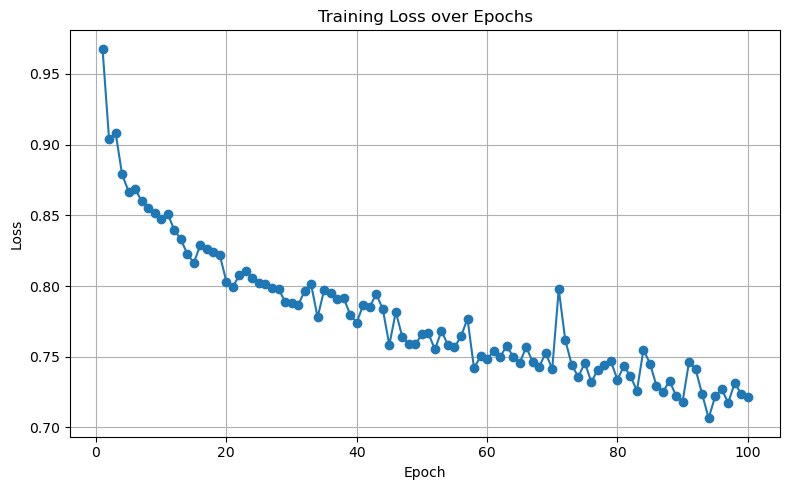

In [21]:
import matplotlib.pyplot as plt

n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

## Метрики классификации

In [22]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.numpy()

        outputs = model(xb)
        pred_labels = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(pred_labels)
        all_true.extend(yb)

acc = accuracy_score(all_true, all_preds)
report = classification_report(all_true, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.6121
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.21      0.26        38
           1       0.67      0.73      0.70       294
           2       0.00      0.00      0.00         8
           3       0.55      0.53      0.54       191

    accuracy                           0.61       531
   macro avg       0.39      0.37      0.38       531
weighted avg       0.59      0.61      0.60       531



In [23]:
label2id

{'hat/mudr/cacta': 0, 'line/l1': 1, 'helitron': 2, 'gypsy/copia': 3}